In [110]:
# !pip install kaggle -q

In [ ]:
# Imports padrão
import os
import zipfile
import random
from glob import glob
from collections import Counter
import shutil

# Manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de imagens
from PIL import Image

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning (Keras)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Importação dos Dados

In [7]:
ZIP_FILE_PATH = 'PlantVillageDataset.zip'
EXTRACTION_PATH = os.path.join(
    'datasets',
    'plant_disease_dataset'
)

# Garante que o diretório exista
os.makedirs(EXTRACTION_PATH, exist_ok=True)

try:
    # Extrai o ZIP
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTION_PATH)

    print(f"Extração concluída com sucesso em: {EXTRACTION_PATH}")

    # Caminho da pasta duplicada
    duplicated_path = os.path.join(
        EXTRACTION_PATH,
        'PlantVillage',
        'PlantVillage'
    )

    # Remove a pasta duplicada, se existir
    if os.path.exists(duplicated_path):
        shutil.rmtree(duplicated_path)

    print(os.listdir(EXTRACTION_PATH)[:10])

except FileNotFoundError:
    print(f"ERRO: Arquivo ZIP não encontrado em: {ZIP_FILE_PATH}")
except Exception as e:
    print(f"Ocorreu um erro durante a extração: {e}")


Extração concluída com sucesso em: datasets\plant_disease_dataset
['PlantVillage']


 # Entendimento dos Dados

In [10]:
BASE_PATH = os.path.join('datasets', 'plant_disease_dataset', 'PlantVillage')

try:
    # Lista as subpastas, que representam as classes (Espécie_Doença)
    classes = sorted(
        d for d in os.listdir(BASE_PATH)
        if os.path.isdir(os.path.join(BASE_PATH, d)) and d != "PlantVillage"
    )

    for i, class_name in enumerate(classes):
        print(f"Classe {i+1}: {class_name}")

except FileNotFoundError:
    print(f"ERRO: O diretório base '{BASE_PATH}' não foi encontrado. Verifique se o ZIP foi extraído corretamente.")
except Exception as e:
    print(f"Ocorreu um erro durante a inspeção da estrutura: {e}")

Classe 1: Pepper__bell___Bacterial_spot
Classe 2: Pepper__bell___healthy
Classe 3: Potato___Early_blight
Classe 4: Potato___Late_blight
Classe 5: Potato___healthy
Classe 6: Tomato_Bacterial_spot
Classe 7: Tomato_Early_blight
Classe 8: Tomato_Late_blight
Classe 9: Tomato_Leaf_Mold
Classe 10: Tomato_Septoria_leaf_spot
Classe 11: Tomato_Spider_mites_Two_spotted_spider_mite
Classe 12: Tomato__Target_Spot
Classe 13: Tomato__Tomato_YellowLeaf__Curl_Virus
Classe 14: Tomato__Tomato_mosaic_virus
Classe 15: Tomato_healthy


In [11]:
class_counts = Counter()
total_imagens = 0

# Faz a contagem em todas as classes
for class_name in classes:
    class_path = os.path.join(BASE_PATH, class_name)
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))])
    class_counts[class_name] = count
    total_imagens += count

df_counts = pd.DataFrame(class_counts.items(), columns=['Classe', 'Contagem'])
df_counts = df_counts.sort_values(by='Contagem', ascending=False)
std_dev = df_counts['Contagem'].std()

print(f"Total Geral de Imagens no Dataset: {total_imagens}")
print(f"Total de Classes (Espécies + Doenças): {len(classes)}")

print(df_counts.head())
print(df_counts.tail())
print(f"\nDesvio Padrão da Contagem de Imagens: {std_dev:.2f}")

Total Geral de Imagens no Dataset: 20637
Total de Classes (Espécies + Doenças): 15
                                         Classe  Contagem
12        Tomato__Tomato_YellowLeaf__Curl_Virus      3208
5                         Tomato_Bacterial_spot      2127
7                            Tomato_Late_blight      1908
9                     Tomato_Septoria_leaf_spot      1771
10  Tomato_Spider_mites_Two_spotted_spider_mite      1676
                           Classe  Contagem
6             Tomato_Early_blight      1000
0   Pepper__bell___Bacterial_spot       997
8                Tomato_Leaf_Mold       952
13    Tomato__Tomato_mosaic_virus       373
4                Potato___healthy       152

Desvio Padrão da Contagem de Imagens: 744.43


C:\Users\a-a-c\AppData\Local\Temp\ipykernel_26528\3534163648.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contagem', y='Classe', data=df_counts, palette="viridis")


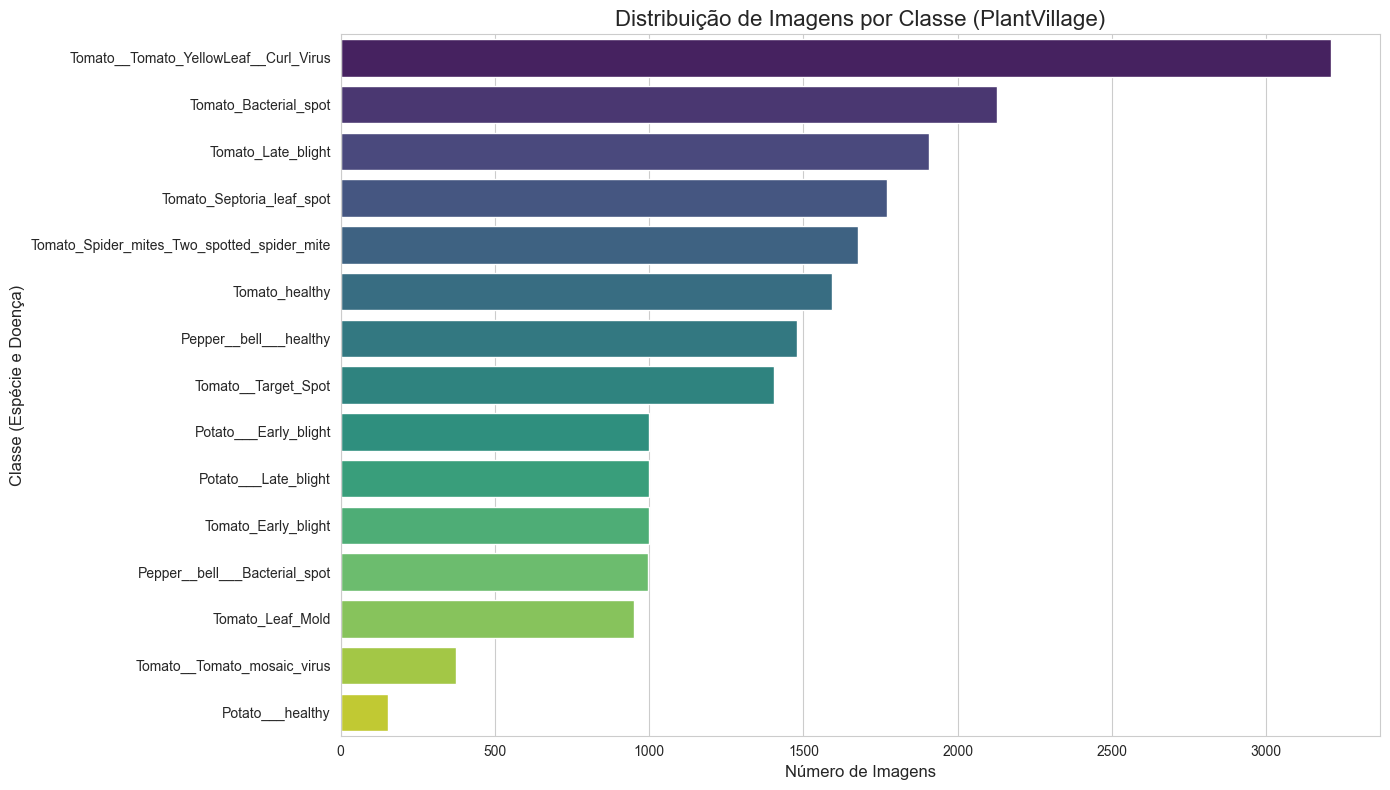

In [12]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Gráfico de barras - Distribuição de Imagens por Classe
sns.barplot(x='Contagem', y='Classe', data=df_counts, palette="viridis")

plt.title('Distribuição de Imagens por Classe (PlantVillage)', fontsize=16)
plt.xlabel('Número de Imagens', fontsize=12)
plt.ylabel('Classe (Espécie e Doença)', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# Análise de Dimensões, Canais de Cor  e Formato
image_info = []
sample_size = 50 

for class_name in classes:
    class_path = os.path.join(BASE_PATH, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
    
    # Amostra um subconjunto para eficiência
    if len(image_files) > sample_size:
        sample_files = np.random.choice(image_files, sample_size, replace=False)
    else:
        sample_files = image_files

    # Processa as imagens amostradas
    for image_file in sample_files:
        try:
            img_path = os.path.join(class_path, image_file)
            with Image.open(img_path) as img:
                info = {
                    'Classe': class_name,
                    'Dimensão': img.size,
                    'Canais': len(img.getbands()),
                    'Formato': img.format
                }
                image_info.append(info)
        except Exception as e:
            print(f"ERRO ao processar {img_path}: {e}")

df_image_info = pd.DataFrame(image_info)

print("Análise de Dimensões")
print(df_image_info['Dimensão'].value_counts())
print("\nAnálise de Canais de Cor")
print(df_image_info['Canais'].value_counts())
print("\nAnálise de Formato")
print(df_image_info['Formato'].value_counts())

Análise de Dimensões
Dimensão
(256, 256)    750
Name: count, dtype: int64

Análise de Canais de Cor
Canais
3    750
Name: count, dtype: int64

Análise de Formato
Formato
JPEG    750
Name: count, dtype: int64


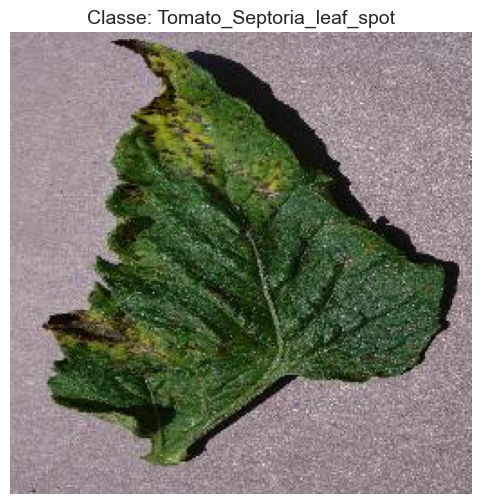

Visualizando: plant_disease_dataset\PlantVillage\Tomato_Septoria_leaf_spot\66b8d334-827c-429e-aac3-f4c80fc07000___Matt.S_CG 6831.JPG


In [117]:
random_class = random.choice(classes)
class_path = os.path.join(BASE_PATH, random_class)
image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]

if image_files:
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(class_path, random_image_file)
    
    try:
        with Image.open(random_image_path) as img:
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"Classe: {random_class}", fontsize=14)
            plt.axis('off')
            plt.show()
            print(f"Visualizando: {random_image_path}")
            
    except Exception as e:
        print(f"ERRO ao carregar ou exibir imagem {random_image_path}: {e}")
else:
    print(f"ERRO: Nenhuma imagem encontrada na classe {random_class}")

# Preparação dos Dados

In [118]:
# Criação do DataFrame de Metadados
all_image_paths = []
all_labels = []

# Lista recursivamente todos os arquivos JPG e PNG
image_files = glob(os.path.join(BASE_PATH, '*/*.jpg')) + glob(os.path.join(BASE_PATH, '*/*.png'))

for file_path in image_files:
    class_name = os.path.basename(os.path.dirname(file_path))
    
    if class_name != 'PlantVillage':
        all_image_paths.append(file_path)
        all_labels.append(class_name)

df_data = pd.DataFrame({
    'file_path': all_image_paths,
    'class_name': all_labels
})

print(f"Total de imagens carregadas no DataFrame: {len(df_data)}")
# %%

Total de imagens carregadas no DataFrame: 20637


In [ ]:
    # 70% Treino, 30% restante (Validação + Teste)
df_train, df_temp = train_test_split(
    df_data,
    test_size=0.30,
    random_state=42,
    shuffle=True,
    stratify=df_data['class_name']
)

# Dividir o 30% restante em Validação (15%) e Teste (15%)
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=df_temp['class_name']
)

print(f"Total Treinamento: {len(df_train)} ({len(df_train)/len(df_data):.2%})")
print(f"Total Validação: {len(df_val)} ({len(df_val)/len(df_data):.2%})")
print(f"Total Teste: {len(df_test)} ({len(df_test)/len(df_data):.2%})")
# %%

Total Treinamento: 14445 (70.00%)
Total Validação: 3096 (15.00%)
Total Teste: 3096 (15.00%)


In [120]:
# Data Augmentation (APENAS para o Treinamento)
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador de Validação/Teste (APENAS Normalização)
val_test_datagen = ImageDataGenerator(rescale=1./255.0)

In [121]:
# Criação dos Data Generators

BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_path',
    y_col='class_name',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='file_path',
    y_col='class_name',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='class_name',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)
# %%

Found 14445 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.


# Modelagem

In [ ]:

# Parâmetros
NUM_CLASSES = len(train_generator.class_indices)
INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) 
# INPUT_SHAPE = (256, 256, 3)

# Criação do modelo CNN
model = Sequential([
    # Convolução e Pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Adicionando profundidade
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening para as Camadas Densas
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5), # Regularização
    
    # Camada de Saída
    Dense(NUM_CLASSES, activation='softmax')
])

# Compilação do Modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\a-a-c\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,086,735 (99.51 MB)

 Trainable params: 26,086,735 (99.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Parâmetros de Callbacks
PATIENCE = 10 
MONITOR_METRIC = 'val_accuracy' 
MODEL_FILEPATH = os.path.join('processed', 'plant_disease_cnn_model.keras')

# Garante que a pasta exista
os.makedirs('processed', exist_ok=True)



# Early Stopping
early_stopping = EarlyStopping(
    monitor=MONITOR_METRIC,
    patience=PATIENCE,
    verbose=1,
    mode='max',
    restore_best_weights=True 
)

# Model Checkpointing
model_checkpoint = ModelCheckpoint(
    filepath=MODEL_FILEPATH,
    monitor=MONITOR_METRIC,
    save_best_only=True,
    mode='max',
    verbose=1
)

# Lista de Callbacks
callbacks_list = [early_stopping, model_checkpoint]

Callbacks EarlyStopping (Paciência: 10) e ModelCheckpoint definidos.


In [ ]:
EPOCHS = 10 

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

Iniciando o treinamento por até 10 epochs...
Epoch 1/10
 63/451 ━━━━━━━━━━━━━━━━━━━━ 6:43 1s/step - accuracy: 0.1580 - loss: 2.7115

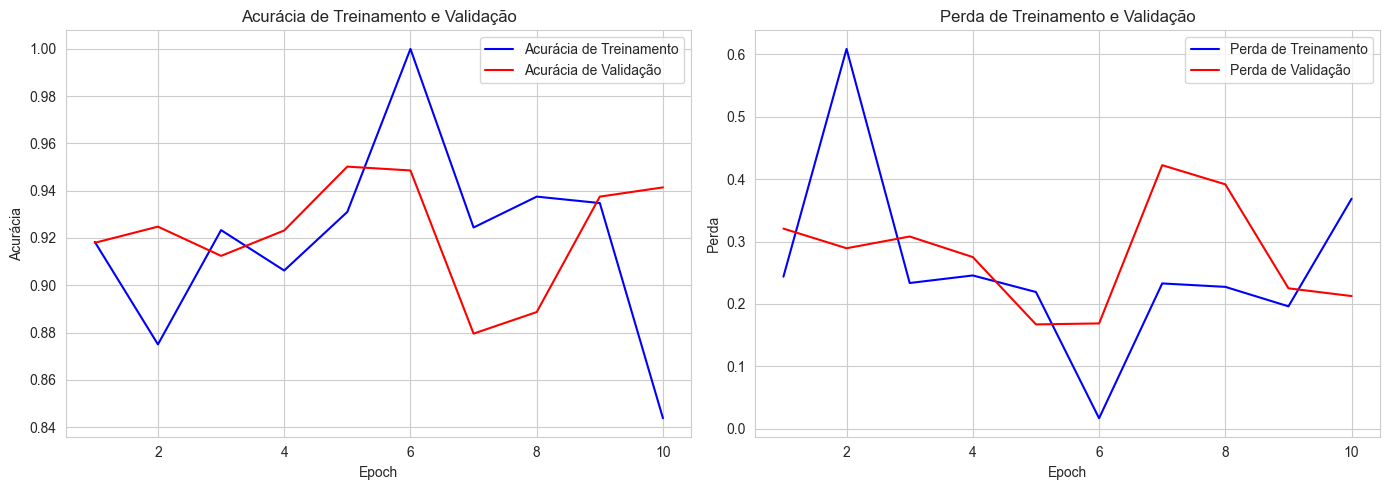

In [ ]:
def plot_training_history(history):
    # Extrai as métricas de acurácia e perda
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Acurácia de Treinamento')
    plt.plot(epochs, val_acc, 'r', label='Acurácia de Validação')
    plt.title('Acurácia de Treinamento e Validação')
    plt.xlabel('Epoch')
    plt.ylabel('Acurácia')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Perda de Treinamento')
    plt.plot(epochs, val_loss, 'r', label='Perda de Validação')
    plt.title('Perda de Treinamento e Validação')
    plt.xlabel('Epoch')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history) 

# Avaliação

In [ ]:
# Carrega o melhor modelo salvo 
best_model = load_model('plant_disease_cnn_model.keras')

# Geração de Predições
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extração de Rótulos Reais
y_true = test_generator.labels

# Mapeamento de Rótulos
label_map = dict((v, k) for k, v in test_generator.class_indices.items())
class_names = [label_map[i] for i in range(len(label_map))]

Gerando predições para o conjunto de Teste...
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 331ms/step


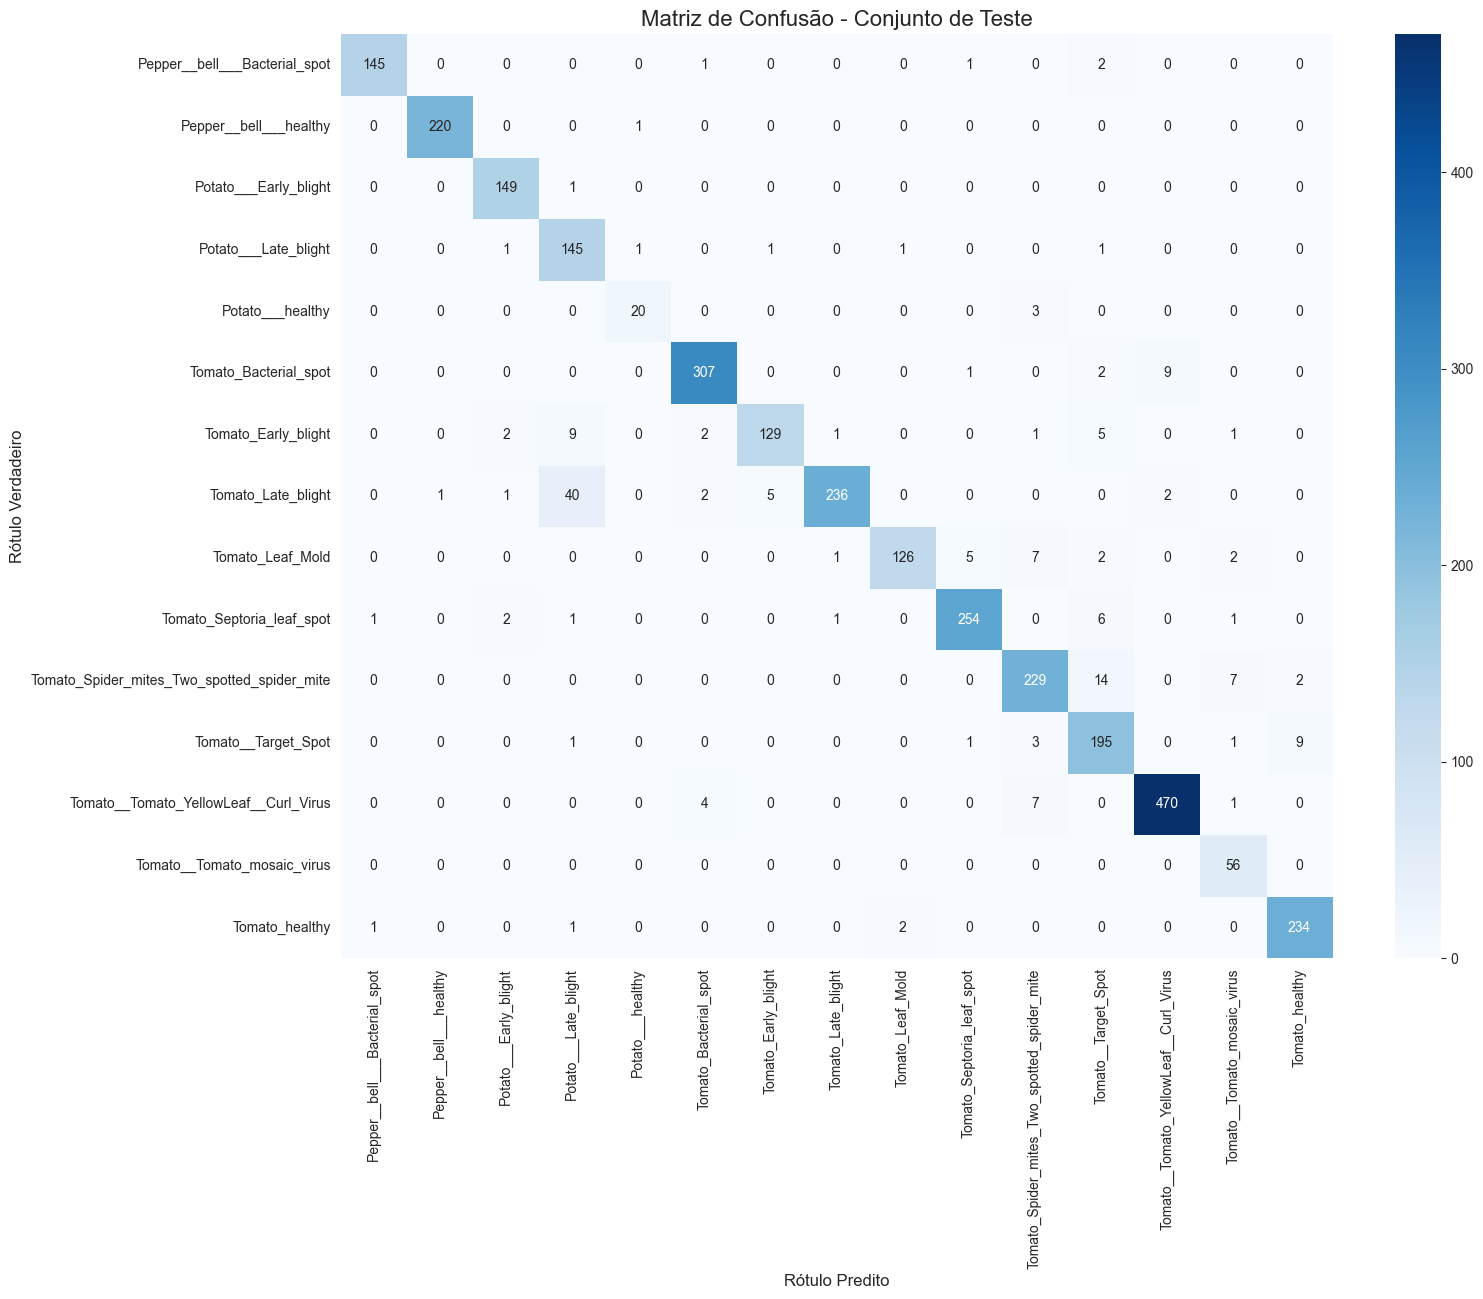

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.xlabel('Rótulo Predito', fontsize=12)
plt.show()

In [ ]:
# Relatório de Classificação
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

--- Relatório de Classificação ---
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9864    0.9732    0.9797       149
                     Pepper__bell___healthy     0.9955    0.9955    0.9955       221
                      Potato___Early_blight     0.9613    0.9933    0.9770       150
                       Potato___Late_blight     0.7323    0.9667    0.8333       150
                           Potato___healthy     0.9091    0.8696    0.8889        23
                      Tomato_Bacterial_spot     0.9715    0.9624    0.9669       319
                        Tomato_Early_blight     0.9556    0.8600    0.9053       150
                         Tomato_Late_blight     0.9874    0.8223    0.8973       287
                           Tomato_Leaf_Mold     0.9767    0.8811    0.9265       143
                  Tomato_Septoria_leaf_spot     0.9695    0.9549    0.9621       266
Tomato_Spider_mites_Two_spott

## Análise Final do Projeto: Classificação de Doenças de Plantas

O objetivo principal deste projeto foi desenvolver um modelo de *Deep Learning* capaz de classificar com alta precisão 15 classes distintas de doenças e estados saudáveis em três espécies de plantas (Tomate, Batata e Pimentão). A acurácia na identificação de doenças é crucial para a agricultura de precisão, permitindo intervenções rápidas e localizadas.

A fonte de dados escolhida foi o *dataset* **PlantVillage do kaggle**. Este *dataset* foi ideal por possuir uma estrutura de diretórios já organizada por classes, o que simplifica a ingestão de dados para redes convolucionais. Além disso, as imagens já se encontravam padronizadas em 256×256 pixels e 3 canais de cor (RGB), eliminando a necessidade de pré-processamento de redimensionamento e conversão de cores.

### Desafios Iniciais e Estratégias de Contorno

O principal desafio técnico identificado foi o **forte desbalanceamento de classes**. Algumas doenças eram amplamente representadas com mais de 3.200 imagens, enquanto outras classes minoritárias tinham menos de 200, o que poderia levar o modelo ao *overfitting* nas classes dominantes.

Para neutralizar esse problema, duas estratégias cruciais foram implementadas na preparação dos dados:

1. **Divisão Estratificada:** O *dataset* foi dividido em Treinamento (70%), Validação (15%) e Teste (15%) de forma **estratificada**. Isso assegurou que a proporção das 15 classes fosse mantida em todos os conjuntos, garantindo uma avaliação imparcial.
2. **Data Augmentation:** Foi aplicada uma rotina robusta de aumento de dados (incluindo rotação, *zoom* e *flip* horizontal) exclusivamente no conjunto de Treinamento. Esta técnica expandiu artificialmente a variedade dos dados, atuando como um poderoso regularizador e mitigando o impacto do desbalanceamento ao fornecer amostras sintéticas para as classes mais raras.

### Escolha e Justificativa do Modelo

Para a fase de Modelagem, optou-se por construir uma **Rede Neural Convolucional (CNN)**, composta por quatro blocos convolucionais e camadas densas finais.

A decisão de não utilizar inicialmente o **Transfer Learning** (com modelos pré-treinados como MobileNet ou ResNet) foi **metodológica**, visando demonstrar a capacidade de projetar e treinar uma arquitetura CNN baseada nos princípios fundamentais de *Deep Learning*. A complexidade de 26 milhões de parâmetros foi considerada adequada para a dimensão do *dataset* e o número de classes.

Para controlar o *overfitting* inerente a modelos com tantos parâmetros, foram utilizadas duas técnicas de regularização: **Dropout** (com taxa de 0.5 nas camadas densas) e **Early Stopping**, que monitorou a acurácia de validação e restaurou o modelo ao ponto de melhor generalização.

### Análise Final e Conclusão

O modelo CNN alcançou uma **Acurácia Geral de 94.15%** e um **Macro F1-score de 0.9319** no conjunto de Teste, demonstrando um resultado robusto e de alta performance para um classificador de 15 classes.

A análise da **Matriz de Confusão** revelou os principais *insights* sobre o desempenho:

- **Alto Desempenho:** O modelo classificou classes como `Pepper__bell___healthy` (quase 100% de precisão) e o `Tomato__Tomato_YellowLeaf__Curl_Virus` com excelência.
- **Limitação Semântica:** A principal limitação foi a **confusão inter-espécies** e **intra-espécie**. O erro mais notável foi a dificuldade em distinguir `Tomato___Late_blight` de `Potato___Late_blight`, ou seja, o modelo estava aprendendo o sintoma visual da doença (mancha ou necrose) em vez de diferenciar as características da folha hospedeira.

### Oportunidades de Melhoria

Para refinar ainda mais a generalização e resolver as confusões semânticas, as seguintes melhorias poderiam ser implementadas em projetos futuros:

1. **Adoção de Transfer Learning:** A abordagem mais imediata e eficaz seria a migração para **Transfer Learning** (e.g., MobileNetV2 ou VGG16). O uso de pesos pré-treinados em ImageNet forneceria extratores de características de baixo nível (bordas, texturas) muito mais sofisticados, o que provavelmente resolveria a confusão entre o mosaico de diferentes espécies.
2. **Regularização Mais Agressiva:** Introduzir *L2 Regularization* nas camadas convolucionais, além do *Dropout*, para penalizar explicitamente pesos grandes e forçar o modelo a ser mais suave e menos propenso à memorização.
3. **Ajuste da Função de Perda:** Explorar funções de perda mais avançadas (como *Focal Loss*) que aplicam pesos de penalidade maiores aos erros cometidos nas classes minoritárias, otimizando diretamente o desempenho onde o desbalanceamento é mais crítico.